# Cab fare prediction 

In [1]:
#Importing Libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ggplot import *
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.tree import export_graphviz
from statsmodels.formula.api import ols

C:\Users\vimal\Anaconda3\lib\site-packages\ggplot\utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,


In [2]:
#Set working directory 
os.chdir("D:/Data Scientist/Project/Car fare prediction")

In [3]:
#check Working directory 
os.getcwd()

'D:\\Data Scientist\\Project\\Car fare prediction'

In [4]:
#Load Train and Test data
train=pd.read_csv("train_cab.csv")
test=pd.read_csv("test.csv")
train.shape

(16067, 7)

In [5]:
test.shape

(9914, 6)

In [6]:
train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1.0
1,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1.0
2,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2.0
3,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1.0
4,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1.0


In [7]:
#check datatypes of train data
train.dtypes

fare_amount           object
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count      float64
dtype: object

In [8]:
#convert datatypes
train['fare_amount'].loc[1123]=430
train['fare_amount']=pd.to_numeric(train['fare_amount'])
train['passenger_count']=train['passenger_count'].astype(object)

C:\Users\vimal\Anaconda3\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [9]:
train.dtypes

fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count       object
dtype: object

# Missing Value Analysis

In [10]:
#Create dataframe with missing percentage
missing_val = pd.DataFrame(train.isnull().sum())

#Reset index
missing_val = missing_val.reset_index()

#Rename variable
missing_val = missing_val.rename(columns = {'index': 'Variables', 0: 'Missing_percentage'})

#Calculate percentage
missing_val['Missing_percentage'] = (missing_val['Missing_percentage']/len(train))*100

#descending order
missing_val = missing_val.sort_values('Missing_percentage', ascending = False).reset_index(drop = True)

In [11]:
missing_val

,Variables,Missing_percentage
0,passenger_count,0.342317
1,fare_amount,0.149374
2,pickup_datetime,0.000000
3,pickup_longitude,0.000000
4,pickup_latitude,0.000000
5,dropoff_longitude,0.000000
6,dropoff_latitude,0.000000


In [12]:
#As Passnenger_count is a categorical variable we will use mode to impute it
train['passenger_count'].value_counts()

1.00       11259
2.00        2322
5.00        1045
3.00         676
4.00         329
6.00         302
0.00          57
43.00          2
53.00          2
87.00          1
35.00          1
55.00          1
58.00          1
0.12           1
5345.00        1
345.00         1
354.00         1
456.00         1
1.30           1
531.20         1
535.00         1
536.00         1
537.00         1
554.00         1
557.00         1
5334.00        1
236.00         1
Name: passenger_count, dtype: int64

In [13]:
#mode- as 1 has occurred for most no. of times we will replace na with 1 i.e Mode

train['passenger_count'] = train['passenger_count'].fillna(1)

In [14]:
#Droping index of missing value present in fare_amount variable as it is target variable.
train = train.dropna()

In [15]:
train.isnull().sum()

fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

# Outlier analysis 

In [16]:
#Pickup latitude range
print("Range of Pickup Latitude is", (min(train['pickup_latitude']),max(train['pickup_latitude'])))

Range of Pickup Latitude is (-74.006893, 401.083332)


In [17]:
#Dropoff latitude range
print("Range of Dropoff Latitude", (min(train['dropoff_latitude']),max(train['dropoff_latitude'])))

Range of Dropoff Latitude (-74.006377, 41.366138)


In [18]:
# now lets see what are the boundaries in test dataset

In [19]:
#longitude boundary
print("Longitude Boundary in test")
min(test.pickup_longitude.min(), test.dropoff_longitude.min()),max(test.pickup_longitude.max(), test.dropoff_longitude.max())

Longitude Boundary in test


(-74.263242, -72.986532)

In [20]:
#latitude boundary
print("Latitude Boundary in test")
min(test.pickup_latitude.min(), test.pickup_latitude.min()),max(test.pickup_latitude.max(), test.pickup_latitude.max())

Latitude Boundary in test


(40.573143, 41.709555)

In [21]:
#set boundaries
boundary={'min_longitude':-74.263242,
              'min_latitude':40.573143,
              'max_longitude':-72.986532, 
              'max_latitude':41.709555}

In [22]:
train.loc[~((train.pickup_longitude >= boundary['min_longitude'] ) & (train.pickup_longitude <= boundary['max_longitude']) &
            (train.pickup_latitude >= boundary['min_latitude']) & (train.pickup_latitude <= boundary['max_latitude']) &
            (train.dropoff_longitude >= boundary['min_longitude']) & (train.dropoff_longitude <= boundary['max_longitude']) &
            (train.dropoff_latitude >=boundary['min_latitude']) & (train.dropoff_latitude <= boundary['max_latitude'])),'outlier']=1
train.loc[((train.pickup_longitude >= boundary['min_longitude'] ) & (train.pickup_longitude <= boundary['max_longitude']) &
            (train.pickup_latitude >= boundary['min_latitude']) & (train.pickup_latitude <= boundary['max_latitude']) &
            (train.dropoff_longitude >= boundary['min_longitude']) & (train.dropoff_longitude <= boundary['max_longitude']) &
            (train.dropoff_latitude >=boundary['min_latitude']) & (train.dropoff_latitude <= boundary['max_latitude'])),'outlier']=0

# Let us drop outlier locations
train=train.loc[train['outlier']==0]
train.drop(['outlier'],axis=1,inplace=True)

In [23]:
train.shape

(15691, 7)

In [24]:
train.loc[train['fare_amount']<1].shape

(5, 7)

In [25]:
train[train['passenger_count']>6]

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
263,4.9,2010-07-12 09:44:33 UTC,-73.983249,40.734655,-73.991278,40.738918,456.0
293,6.1,2011-01-18 23:48:00 UTC,-74.006642,40.738927,-74.010828,40.717907,5334.0
356,8.5,2013-06-18 10:27:05 UTC,-73.992108,40.764203,-73.973000,40.762695,535.0
386,8.1,2009-08-21 19:35:05 UTC,-73.960853,40.761557,-73.976335,40.748361,354.0
971,10.1,2010-11-21 01:41:00 UTC,-74.004500,40.742143,-73.994330,40.720412,554.0
1007,3.7,2010-12-14 14:46:00 UTC,-73.969157,40.759000,-73.968763,40.764617,53.0
1043,5.7,2012-08-22 22:08:29 UTC,-73.973573,40.760184,-73.953564,40.767392,35.0
1107,4.9,2009-08-08 21:50:50 UTC,-73.988977,40.721068,-73.982368,40.732064,345.0
1146,8.0,2014-03-27 08:05:01 UTC,-73.991098,40.770655,-73.976933,40.790070,5345.0
1200,9.7,2011-08-16 09:29:00 UTC,-73.980487,40.741610,-73.980617,40.746868,536.0


In [26]:
train[train['passenger_count']<=0]

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
314,34.0,2015-06-02 23:16:15 UTC,-73.974899,40.751095,-73.908546,40.881878,0.0
566,4.9,2012-01-28 21:33:18 UTC,-73.955322,40.782840,-73.955797,40.773673,0.0
678,6.5,2012-02-27 07:24:20 UTC,-73.983397,40.738183,-73.971395,40.758023,0.0
1160,13.3,2011-05-25 23:58:48 UTC,-73.998360,40.740348,-73.946455,40.777348,0.0
1935,10.1,2011-10-23 11:09:28 UTC,-73.971400,40.795000,-73.967900,40.768600,0.0
2200,8.1,2011-05-23 16:54:19 UTC,-73.988008,40.748303,-74.005185,40.738733,0.0
2425,8.9,2011-11-25 22:47:33 UTC,-73.999900,40.738600,-73.971800,40.746300,0.0
3034,5.7,2011-03-06 12:03:14 UTC,-73.986557,40.745783,-73.994545,40.729995,0.0
3413,7.3,2011-02-28 06:39:16 UTC,-73.973413,40.743708,-73.985220,40.741583,0.0
3481,11.3,2011-11-30 17:23:02 UTC,-73.968100,40.762500,-73.984400,40.760900,0.0


In [27]:
# Droping the data indexs which contain improper no of passenger as a car accommodate maximum 6 pepole and zero which is no value
train = train.drop(train[train['passenger_count']>6].index, axis = 0)
train = train.drop(train[train['passenger_count']<=0].index, axis = 0)

# Feature engineering

In [28]:
#Now let us extract important features from pickup_datetime

In [29]:
#lets create a function to get important features from pickup_datetime variable in train and test datasets
def clean(data):
    data['pickup_datetime']=data.pickup_datetime.str.slice(-23,-3)
    data['pickup_datetime']=pd.to_datetime(data.pickup_datetime)
    data['day'] = data['pickup_datetime'].dt.day
    data['year'] = data['pickup_datetime'].dt.year 
    data['month'] = data['pickup_datetime'].dt.month 
    data['hour'] = data['pickup_datetime'].dt.hour 
    data['weekday'] = data['pickup_datetime'].dt.weekday
    data=data.dropna(subset=['year','month','hour','weekday'])
    return data

In [30]:
train=clean(train)

In [31]:
train.shape

(15618, 12)

In [32]:
test=clean(test)

In [33]:
test.shape

(9914, 11)

In [34]:
# Now let's calculate trip distance from picup and dropoff latitude and longitude

In [35]:
def trip_distance(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6371 * c  
    return km

In [36]:
train['trip_distance']=trip_distance(train['pickup_longitude'],train['pickup_latitude'],
                                     train['dropoff_longitude'],train['dropoff_latitude'])

In [37]:
train.shape

(15618, 13)

In [38]:
train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,day,year,month,hour,weekday,trip_distance
0,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1.0,15.0,2009.0,6.0,17.0,0.0,1.030764
1,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1.0,5.0,2010.0,1.0,16.0,1.0,8.450134
2,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2.0,18.0,2011.0,8.0,0.0,3.0,1.389525
3,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1.0,21.0,2012.0,4.0,4.0,5.0,2.799270
4,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1.0,9.0,2010.0,3.0,7.0,1.0,1.999157


In [39]:
test['trip_distance']=trip_distance(test['pickup_longitude'],test['pickup_latitude'],
                                     test['dropoff_longitude'],test['dropoff_latitude'])

In [40]:
test.shape

(9914, 12)

In [41]:
#Now look at the summary of the data
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,day,year,month,hour,weekday,trip_distance
count,15618.000000,15618.000000,15618.000000,15618.000000,15618.000000,15618.000000,15618.000000,15618.000000,15618.000000,15618.000000,15618.000000,15618.000000
mean,15.125506,-73.974733,40.751370,-73.973780,40.751912,1.647805,15.667435,2011.735562,6.268216,13.501601,3.032975,3.370256
std,436.271418,0.041158,0.031331,0.039066,0.033251,1.263988,8.685282,1.869602,3.448256,6.506027,1.970488,4.113046
min,-3.000000,-74.181602,40.604462,-74.183955,40.574652,0.120000,1.000000,2009.000000,1.000000,0.000000,0.000000,0.000000
25%,6.000000,-73.992387,40.736664,-73.991371,40.736401,1.000000,8.000000,2010.000000,3.000000,9.000000,1.000000,1.257422
50%,8.500000,-73.982059,40.753357,-73.980572,40.754260,1.000000,16.000000,2012.000000,6.000000,14.000000,3.000000,2.170588
75%,12.500000,-73.968109,40.767805,-73.965399,40.768336,2.000000,23.000000,2013.000000,9.000000,19.000000,5.000000,3.896317
max,54343.000000,-73.137393,41.366138,-73.137393,41.366138,6.000000,31.000000,2015.000000,12.000000,23.000000,6.000000,101.094619


1.look at the summary of fare_amount,passenger_count and trip_distance

2.fare_amount has minimun value as negative value which is not possible so we will drop negative values

3.passenger_count has minimum value 0 which also does not have any significant value for our model so we will drop it

4.trip_distance also has minimum value as 0 which is also of no use

In [42]:
#let's clean fare_amount variable
train=train.drop(train[(train.fare_amount<=1) | (train.fare_amount>=100)].index,axis=0)

In [43]:
#Removing all the passenger_counts having value zero or more than six
train=train[train['passenger_count']<=6]
train=train[train['passenger_count']>=1]

In [44]:
#lets check values of passenger_counts
train['passenger_count'].value_counts()

1.0    11030
2.0     2277
5.0     1022
3.0      661
4.0      319
6.0      294
1.3        1
Name: passenger_count, dtype: int64

In [45]:
#There cannot be 1.3 passenger so lets remove it

In [46]:
train=train[train['passenger_count']!=1.3]

In [47]:
##Now remove the trip_distance having value less than 0.2 as most of people will not take a cab for distance below 200 meters
train = train.loc[train['trip_distance'] >=0.2]

In [48]:
train['trip_distance'].value_counts()

1.205594     1
2.349355     1
1.982825     1
4.394108     1
0.668641     1
5.928567     1
23.114168    1
1.585711     1
0.922657     1
0.913702     1
1.188663     1
0.674342     1
1.207652     1
1.278791     1
3.992394     1
4.552301     1
0.501814     1
1.347000     1
1.151461     1
3.822716     1
10.014005    1
2.037528     1
4.514271     1
1.505143     1
14.870877    1
2.951894     1
16.072719    1
2.175169     1
1.677110     1
5.782315     1
            ..
11.193472    1
3.787896     1
1.363578     1
2.232374     1
7.758761     1
0.505729     1
3.548057     1
1.234933     1
3.162916     1
2.802399     1
4.003733     1
4.888723     1
1.022957     1
1.029709     1
1.701748     1
1.455731     1
0.813612     1
0.865508     1
4.014669     1
8.895000     1
4.089886     1
4.563374     1
3.209962     1
2.020355     1
12.008564    1
1.739986     1
2.598696     1
1.205716     1
0.759526     1
0.705864     1
Name: trip_distance, Length: 15317, dtype: int64

In [49]:
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,day,year,month,hour,weekday,trip_distance
count,15317.000000,15317.000000,15317.000000,15317.000000,15317.000000,15317.000000,15317.000000,15317.000000,15317.000000,15317.000000,15317.000000,15317.000000
mean,11.272861,-73.975267,40.751211,-73.974292,40.751736,1.649866,15.662271,2011.741333,6.274793,13.507018,3.036495,3.430912
std,9.222521,0.037529,0.029028,0.035203,0.031063,1.266088,8.685797,1.870989,3.449202,6.506363,1.970940,4.114236
min,1.140000,-74.133710,40.609495,-74.183955,40.574652,1.000000,1.000000,2009.000000,1.000000,0.000000,0.000000,0.200437
25%,6.000000,-73.992409,40.736696,-73.991372,40.736427,1.000000,8.000000,2010.000000,3.000000,9.000000,1.000000,1.299848
50%,8.500000,-73.982095,40.753370,-73.980598,40.754270,1.000000,16.000000,2012.000000,6.000000,14.000000,3.000000,2.210491
75%,12.500000,-73.968273,40.767803,-73.965605,40.768332,2.000000,23.000000,2013.000000,9.000000,19.000000,5.000000,3.955770
max,95.000000,-73.137393,41.366138,-73.137393,41.366138,6.000000,31.000000,2015.000000,12.000000,23.000000,6.000000,101.094619


# Feature Engineering

In [50]:
#first look at the relation between trip_distance and fare_amount

Text(0.5, 1.0, 'Trip Distance vs Fare Amount')

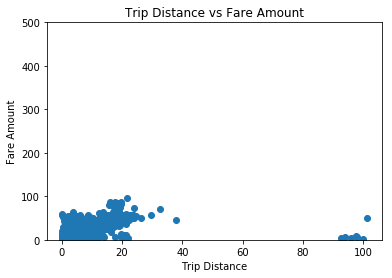

In [51]:
plt.scatter(x=train['trip_distance'],y=train['fare_amount'])
plt.xlabel("Trip Distance")
plt.ylabel("Fare Amount")
plt.ylim(0, 500)
plt.title("Trip Distance vs Fare Amount")

# As you can see in scatterplot that fare amount is almost fixed for trip over 80 kms.

In [52]:
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,day,year,month,hour,weekday,trip_distance
count,15317.000000,15317.000000,15317.000000,15317.000000,15317.000000,15317.000000,15317.000000,15317.000000,15317.000000,15317.000000,15317.000000,15317.000000
mean,11.272861,-73.975267,40.751211,-73.974292,40.751736,1.649866,15.662271,2011.741333,6.274793,13.507018,3.036495,3.430912
std,9.222521,0.037529,0.029028,0.035203,0.031063,1.266088,8.685797,1.870989,3.449202,6.506363,1.970940,4.114236
min,1.140000,-74.133710,40.609495,-74.183955,40.574652,1.000000,1.000000,2009.000000,1.000000,0.000000,0.000000,0.200437
25%,6.000000,-73.992409,40.736696,-73.991372,40.736427,1.000000,8.000000,2010.000000,3.000000,9.000000,1.000000,1.299848
50%,8.500000,-73.982095,40.753370,-73.980598,40.754270,1.000000,16.000000,2012.000000,6.000000,14.000000,3.000000,2.210491
75%,12.500000,-73.968273,40.767803,-73.965605,40.768332,2.000000,23.000000,2013.000000,9.000000,19.000000,5.000000,3.955770
max,95.000000,-73.137393,41.366138,-73.137393,41.366138,6.000000,31.000000,2015.000000,12.000000,23.000000,6.000000,101.094619


#now you can see after removing ouliers max value and mean of fare_amount has been changed

# Feature Selection
1.Correlation Analysis

Statistically correlated: features move together directionally.
Linear models assume feature independence.
And if features are correlated that could introduce bias into our models.

In [95]:
train.shape

(15317, 13)

In [96]:
train.nunique()

fare_amount            441
pickup_datetime      15273
pickup_longitude     13443
pickup_latitude      13890
dropoff_longitude    13535
dropoff_latitude     13896
passenger_count          6
day                     31
year                     7
month                   12
hour                    24
weekday                  7
trip_distance        15317
dtype: int64

In [101]:
cnames = ['fare_amount','pickup_datetime','pickup_longitude',
                   'pickup_latitude','dropoff_longitude','dropoff_latitude','trip_distance']

catnames = ['passenger_count', 'day','hour','weekday','month','year']

In [102]:
train_corr = train.loc[:,cnames]

In [103]:
train_corr.head(5)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_distance
0,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1.030764
1,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,8.450134
2,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,1.389525
3,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,2.799270
4,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1.999157


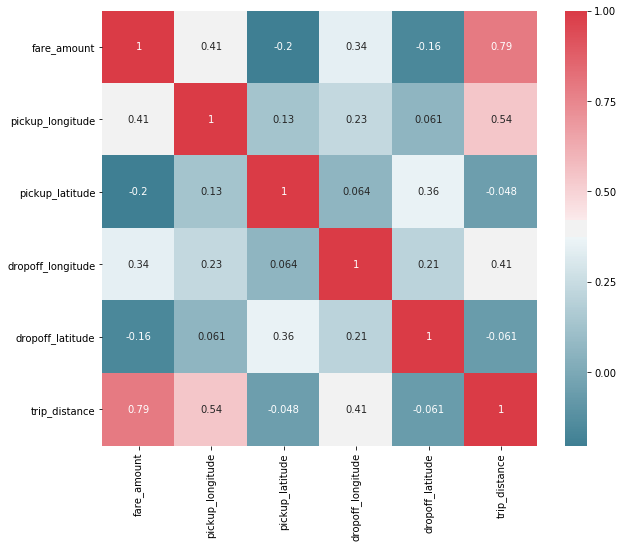

In [104]:
# set width and hight of the plot

f,ax=plt.subplots(figsize=(10,8))

#generating corr plot

corr=train_corr.corr()

# plot using seaborn lib

sns.heatmap(corr,mask=np.zeros_like(corr,dtype=np.bool),annot=True,cmap=sns.diverging_palette(220,10,as_cmap=True),square=True,ax=ax)

# Analysis of Variance(Anova) Test
It is carried out to compare between each groups in a categorical variable. ANOVA only lets us know the means for different groups are same or not. It doesn’t help us identify which mean is different. Hypothesis testing : Null Hypothesis: mean of all categories in a variable are same. Alternate Hypothesis: mean of at least one category in a variable is different. If p-value is less than 0.05 then we reject the null hypothesis. And if p-value is greater than 0.05 then we accept the null hypothesis.

In [107]:
aov=ols('fare_amount~passenger_count+day+hour+weekday+month+year',data=train).fit()

In [108]:
aov_table=sm.stats.anova_lm(aov,typ=2)

In [109]:
aov_table

,sum_sq,df,F,PR(>F)
passenger_count,1.053898e+02,1.0,1.262270,2.612395e-01
day,3.401231e+00,1.0,0.040737,8.400490e-01
hour,1.454871e+03,1.0,17.425215,3.004871e-05
weekday,2.577926e+01,1.0,0.308762,5.784489e-01
month,3.936839e+03,1.0,47.152116,6.821303e-12
year,2.060177e+04,1.0,246.750550,3.577101e-55
Residual,1.278267e+06,15310.0,NaN,NaN


Every variable has p-value less than 0.05 therefore we reject the null hypothesis.

From the above analysis we observe that we dont find any collinearity and multicollinearity effect so we proceed without any action.

In [53]:
# train.to_csv("trained_data.csv", index=False)

In [54]:
# test.to_csv("processed_test_data.csv",index=False)

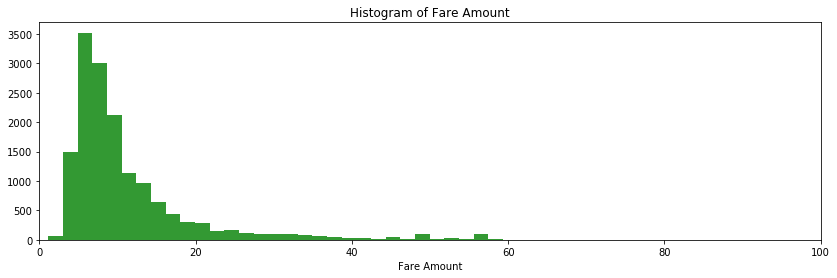

In [55]:
#let's visualize fare_amount
plt.figure(figsize = (14, 4))
n, bins, patches = plt.hist(train.fare_amount, 50, facecolor='green', alpha=0.8)
plt.xlabel('Fare Amount')
plt.title('Histogram of Fare Amount')
plt.xlim(0, 100)
plt.show();

#As we can see in the histogram most Fare drops between 5 to 15 dollars indicating short trips

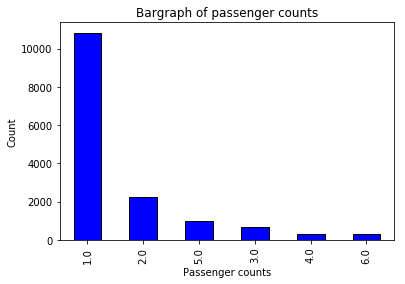

In [56]:
#Now lets visualize passenger_count
train['passenger_count'].value_counts().plot.bar(color = 'blue', edgecolor = 'black');
plt.title('Bargraph of passenger counts'); plt.xlabel('Passenger counts'); plt.ylabel('Count');

You can see in the above bargraph that most of the time single passengers have booked cab and family booking is least

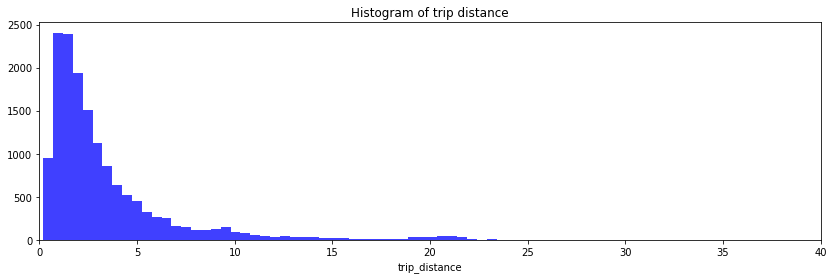

In [57]:
#lets visualize the trip_distance\
plt.figure(figsize = (14, 4))
n, bins, patches = plt.hist(train.trip_distance, 200, facecolor='blue', alpha=0.75)
plt.xlabel('trip_distance')
plt.xlim(0, 40)
plt.title('Histogram of trip distance')
plt.show();

In the above histogram we can see that maximum no. of times people took short trips between somewhere 0.7 to 3 KM

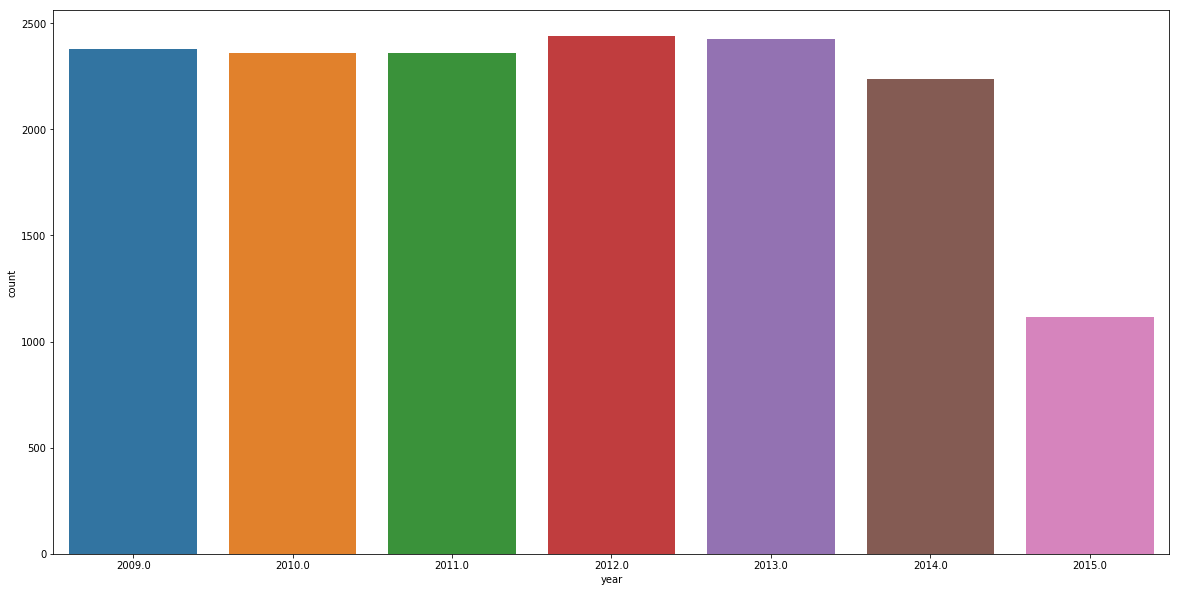

In [89]:
#Lets visualize the pickup year 
plt.figure(figsize=(20,10))
sns.countplot(train['year'])
# plt.savefig('year.png')

In this plot we can from 2009 to 2014 was similar trip count and in 2015 trips was less.

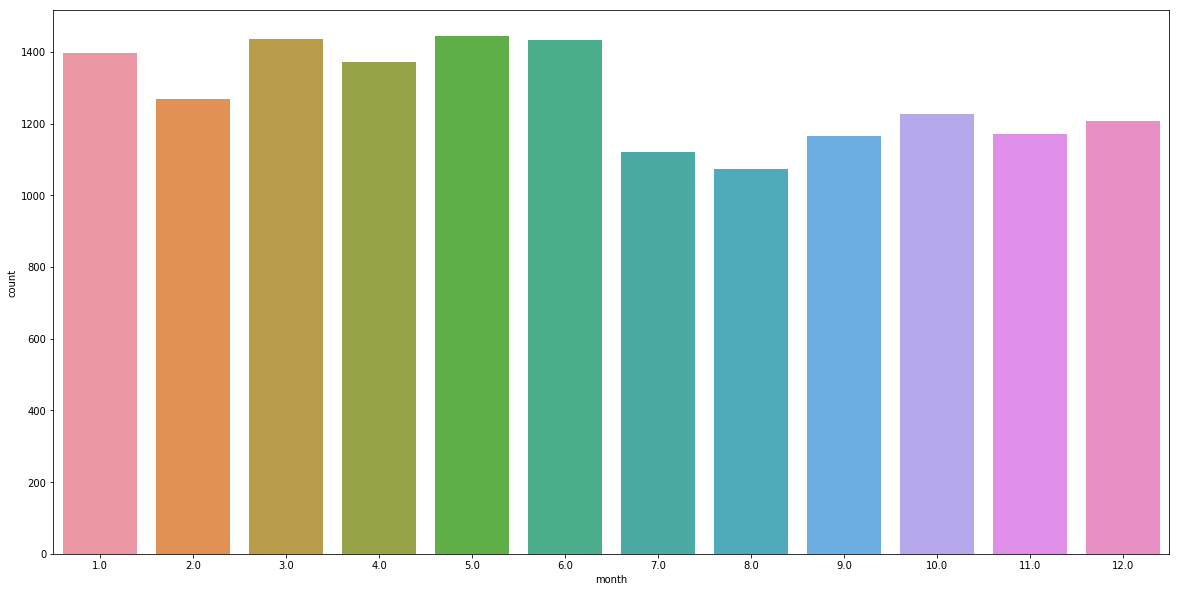

In [90]:
plt.figure(figsize=(20,10))
sns.countplot(train['month'])
# plt.savefig('month.png')

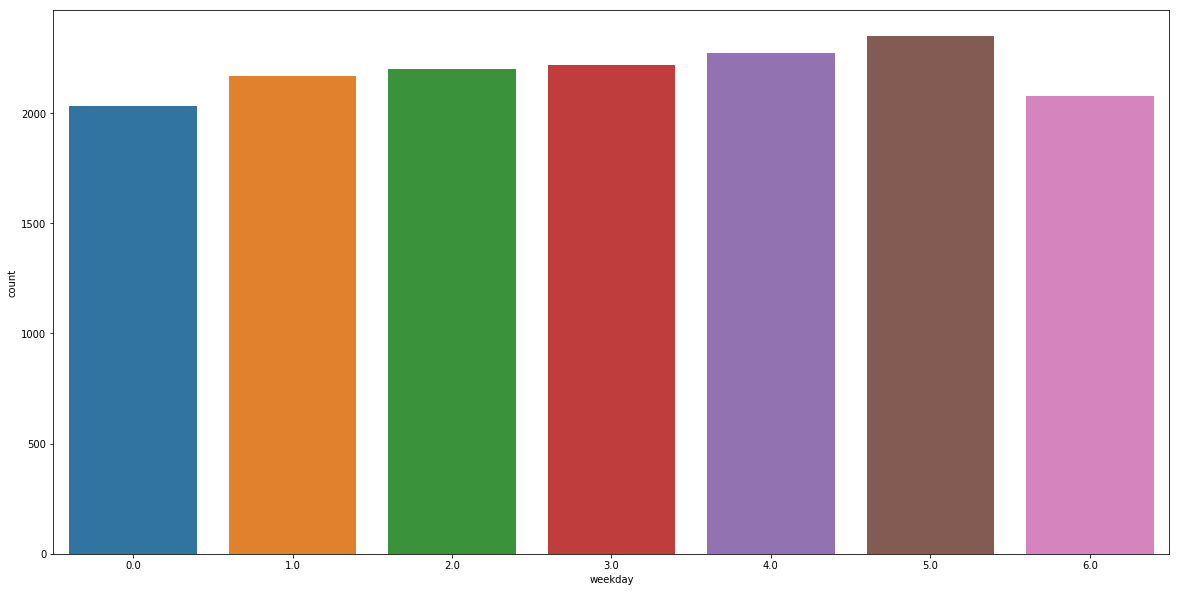

In [91]:
plt.figure(figsize=(20,10))
sns.countplot(train['weekday'])
# plt.savefig('day_of_week.png')

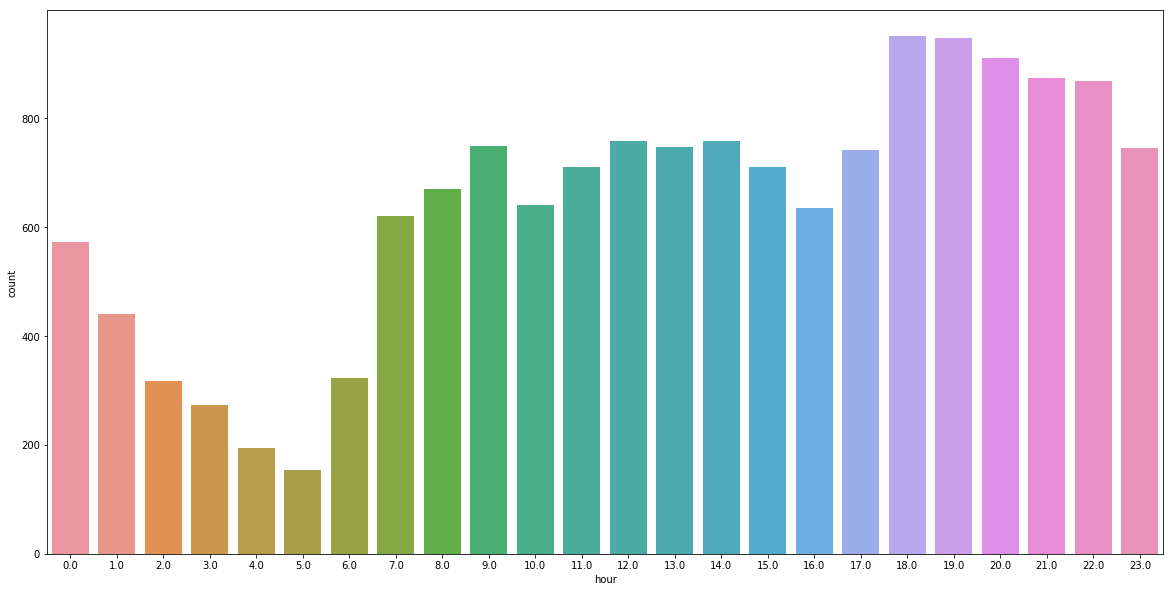

In [92]:

plt.figure(figsize=(20,10))
sns.countplot(train['hour'])
# plt.savefig('hour.png')

As we observe the no of trips are high in the evening time i.e; 1700hrs to 2300hrs so company can provide more cabs during that time.

In [58]:
train.shape

(15317, 13)

# Data Sampling

In [59]:
def modeling(data,target,drop_cols,split=0.25):
    new_data=data.drop(drop_cols,axis=1)
    X=new_data.drop([target],axis=1)
    y=new_data[target]
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=split,random_state=42)
    print("train shape",X_train.shape)
    print("test shape",X_test.shape)
    return X_train, X_test, y_train, y_test
    return new_data

In [60]:
X_train, X_test, y_train, y_test=modeling(train,'fare_amount',drop_cols=['pickup_datetime'],split=0.2)

train shape (12253, 11)
test shape (3064, 11)


In [61]:
train.dtypes

fare_amount                 float64
pickup_datetime      datetime64[ns]
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count             float64
day                         float64
year                        float64
month                       float64
hour                        float64
weekday                     float64
trip_distance               float64
dtype: object

In [62]:
train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,day,year,month,hour,weekday,trip_distance
0,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1.0,15.0,2009.0,6.0,17.0,0.0,1.030764
1,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1.0,5.0,2010.0,1.0,16.0,1.0,8.450134
2,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2.0,18.0,2011.0,8.0,0.0,3.0,1.389525
3,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1.0,21.0,2012.0,4.0,4.0,5.0,2.799270
4,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1.0,9.0,2010.0,3.0,7.0,1.0,1.999157


In [63]:
test.dtypes

pickup_datetime      datetime64[ns]
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count               int64
day                           int64
year                          int64
month                         int64
hour                          int64
weekday                       int64
trip_distance               float64
dtype: object

# Model Development

# Linear Regression

In [64]:
# Train the model using the training sets
model1 = sm.OLS(y_train, X_train).fit()

In [65]:
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            fare_amount   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     6891.
Date:                Thu, 10 Oct 2019   Prob (F-statistic):               0.00
Time:                        16:36:56   Log-Likelihood:                -38048.
No. Observations:               12253   AIC:                         7.612e+04
Df Residuals:                   12242   BIC:                         7.620e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
pickup_longitude     -8.5230      1.238     -6.886      0.000     -10.949      -6.097
pickup_latitude     -35.6797      1.732    -20.604      0.000     -39.074     -32.285
dropoff_longitude    -1.8799      1.221     -1.540      0.124      -4.273       0.513
dropoff_latitude    -16.8597      1.618    -10.420      0.000     -20.031     -13.688
passenger_count       0.0950      0.039      2.452      0.014       0.019       0.171
day                  -0.0027      0.006     -0.483      0.629      -0.014       0.008
year                  0.6840      0.025     26.912      0.000       0.634       0.734
month                 0.1117      0.014      7.820      0.000       0.084       0.140
hour                  0.0051      0.008      0.676      0.499      -0.010       0.020
weekday              -0.0758      0.025     -3.036      0.002      -0.125      -0.027
trip_distance         1.7582      0.013    138.924      0.000       1.733       1.783
==============================================================================
Omnibus:                    15845.728   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         26017002.213
Skew:                          -6.364   Prob(JB):                         0.00
Kurtosis:                     228.383   Cond. No.                     8.72e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.72e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [66]:
y_pred1=model1.predict(X_test)

In [67]:
lm_rmse=np.sqrt(mean_squared_error(y_pred1, y_test))
print("RMSE for Linear Regression is ",lm_rmse)

RMSE for Linear Regression is  5.109617129295344


# Now lets try another linear regression by changing split

In [68]:
X_train1, X_test1, y_train1, y_test1=modeling(train,'fare_amount',drop_cols=['pickup_datetime'],split=0.3)

train shape (10721, 11)
test shape (4596, 11)


In [69]:
# Train the model using the training sets
model2 = sm.OLS(y_train1, X_train1).fit()

In [70]:
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            fare_amount   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     5759.
Date:                Thu, 10 Oct 2019   Prob (F-statistic):               0.00
Time:                        16:36:57   Log-Likelihood:                -33502.
No. Observations:               10721   AIC:                         6.703e+04
Df Residuals:                   10710   BIC:                         6.711e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
pickup_longitude     -9.9777      1.335     -7.475      0.000     -12.594      -7.361
pickup_latitude     -38.3202      1.870    -20.497      0.000     -41.985     -34.656
dropoff_longitude    -1.5574      1.322     -1.178      0.239      -4.149       1.035
dropoff_latitude    -17.7732      1.758    -10.109      0.000     -21.219     -14.327
passenger_count       0.1000      0.042      2.373      0.018       0.017       0.183
day                  -0.0041      0.006     -0.662      0.508      -0.016       0.008
year                  0.7144      0.028     25.772      0.000       0.660       0.769
month                 0.1120      0.016      7.192      0.000       0.081       0.143
hour                  0.0060      0.008      0.724      0.469      -0.010       0.022
weekday              -0.0672      0.027     -2.471      0.013      -0.121      -0.014
trip_distance         1.7107      0.014    125.310      0.000       1.684       1.737
==============================================================================
Omnibus:                    13346.449   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         17813388.936
Skew:                          -5.945   Prob(JB):                         0.00
Kurtosis:                     202.338   Cond. No.                     8.68e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.68e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [110]:
#From the summary of the linear regression model 
# R-squared value is 0.855 thatis the linear regression model explains 85.5% of the target variable is explained by the all independent varibles.

In [71]:
y_pred2=model2.predict(X_test1)

In [72]:
lm_rmse=np.sqrt(mean_squared_error(y_pred2, y_test1))
print("RMSE for Linear Regression is ",lm_rmse)

RMSE for Linear Regression is  4.98004112143323


# DecisionTree

In [73]:
#Decision tree for regression
fit_DT = DecisionTreeRegressor(max_depth=6,random_state=42).fit(X_train, y_train)

In [74]:
predictions_DT = fit_DT.predict(X_test)

Lets use RMSE to test accuracy of the Model

In [75]:
dt_rmse=np.sqrt(mean_squared_error(predictions_DT,y_test))
print("RMSE = ",dt_rmse)

RMSE =  3.6116131495166313


# Random Forest

In [76]:
fit_RF = RandomForestRegressor(n_estimators = 50,random_state=42).fit(X_train,y_train)

In [77]:
prediction_RF=fit_RF.predict(X_test)

In [78]:
rf_rmse=np.sqrt(mean_squared_error(prediction_RF,y_test))
print("RMSE = ",rf_rmse)

RMSE =  3.1090526116252497


# As we got best Accuracy with RandomForest Model we will use this Model to predict Fare

In [79]:
test.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,day,year,month,hour,weekday,trip_distance
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974722,40.751041,-73.973657,40.751743,1.671273,16.194170,2011.815816,6.857979,13.467420,2.852834,3.435371
std,0.042774,0.033541,0.039072,0.035435,1.278747,8.838482,1.803347,3.353272,6.868584,1.994451,3.972374
min,-74.252193,40.573143,-74.263242,40.568973,1.000000,1.000000,2009.000000,1.000000,0.000000,0.000000,0.000000
25%,-73.992501,40.736125,-73.991247,40.735254,1.000000,9.000000,2010.000000,4.000000,8.000000,1.000000,1.298277
50%,-73.982326,40.753051,-73.980015,40.754065,1.000000,16.000000,2012.000000,7.000000,15.000000,3.000000,2.217412
75%,-73.968013,40.767113,-73.964059,40.768757,2.000000,25.000000,2014.000000,10.000000,19.000000,5.000000,4.045302
max,-72.986532,41.709555,-72.990963,41.696683,6.000000,31.000000,2015.000000,12.000000,23.000000,6.000000,99.996040


In [80]:
test.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,day,year,month,hour,weekday,trip_distance
0,2015-01-27 13:08:24,-73.973320,40.763805,-73.981430,40.743835,1,27,2015,1,13,1,2.323259
1,2015-01-27 13:08:24,-73.986862,40.719383,-73.998886,40.739201,1,27,2015,1,13,1,2.425353
2,2011-10-08 11:53:44,-73.982524,40.751260,-73.979654,40.746139,1,8,2011,10,11,5,0.618628
3,2012-12-01 21:12:12,-73.981160,40.767807,-73.990448,40.751635,1,1,2012,12,21,5,1.961033
4,2012-12-01 21:12:12,-73.966046,40.789775,-73.988565,40.744427,1,1,2012,12,21,5,5.387301


In [81]:
test=test.drop(['pickup_datetime'], axis=1)

In [82]:
test.shape

(9914, 11)

In [83]:
predicted_fare=fit_RF.predict(test)

In [84]:
test['predicted_fare']=predicted_fare

In [85]:
test.head(10)

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,day,year,month,hour,weekday,trip_distance,predicted_fare
0,-73.973320,40.763805,-73.981430,40.743835,1,27,2015,1,13,1,2.323259,10.6660
1,-73.986862,40.719383,-73.998886,40.739201,1,27,2015,1,13,1,2.425353,12.0066
2,-73.982524,40.751260,-73.979654,40.746139,1,8,2011,10,11,5,0.618628,4.4700
3,-73.981160,40.767807,-73.990448,40.751635,1,1,2012,12,21,5,1.961033,8.7660
4,-73.966046,40.789775,-73.988565,40.744427,1,1,2012,12,21,5,5.387301,15.8740
5,-73.960983,40.765547,-73.979177,40.740053,1,1,2012,12,21,5,3.222549,10.2140
6,-73.949013,40.773204,-73.959622,40.770893,1,6,2011,10,12,3,0.929601,5.3760
7,-73.777282,40.646636,-73.985083,40.759368,1,6,2011,10,12,3,21.540102,46.9542
8,-74.014099,40.709638,-73.995106,40.741365,1,6,2011,10,12,3,3.873962,12.3280
9,-73.969582,40.765519,-73.980686,40.770725,1,18,2014,2,15,1,1.099794,6.8000


In [86]:
test.to_csv("test_predicted_py.csv",index=False)
